In [ ]:
!sudo apt install libblas-dev llvm python3-pip python3-scipy
!virtualenv --system-site-packages -p python3 env
!source env/bin/activate
!pip install llvmlite==0.15.0
!pip install numba==0.30.1
!pip install librosa

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libblas-dev is already the newest version (3.10.0-2ubuntu1).
llvm is already the newest version (1:14.0-55~exp2).
python3-scipy is already the newest version (1.8.0-1exp2ubuntu1).
python3-pip is already the newest version (22.0.2+dfsg-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/bin/bash: line 1: virtualenv: command not found
/bin/bash: line 1: env/bin/activate: No such file or directory
  Using cached llvmlite-0.15.0.tar.gz (95 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llvmlite
  Running setup.py clean for llvmlite
Failed to build llvmlite
ERROR: Could not build wheels for llvmlite, which i

In [ ]:
!pip install utils
!pip install pretty_midi

In [ ]:
#import all necessary libraries
import math
import argparse
import hashlib
import random
import librosa
import os
import numpy as np
import utils
import pretty_midi
import shutil
import torch
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!nvidia-smi #to monitor GPU storage

Thu Aug  3 17:34:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Data Pre-processing**

For training of the classifier model, we use the dataset downloaded from Github which contains



Firstly we load the dataset to colab

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
adl_path = '/content/drive/MyDrive/adl-piano-midi'

In [ ]:
VALID_NAME_CHARS = ["_", "-", "(", ")", ","]

MIDI_EXTENSIONS = [".mid", ".midi", ".MID", ".MIDI"]

def get_midi_files(files):
    midi_files = []
    for file_name in files:
        # Check if it is a midi file
        _, extension = os.path.splitext(file_name)
        if extension in MIDI_EXTENSIONS:
            midi_files.append(file_name)

    return midi_files

In [ ]:
def adl_load_dataset(adl_path):
    adl_dataset = {}

    # Read all MIDI songs
    for dir, _ , files in os.walk(adl_path):
        if len(files) == 0:
            continue

        artist_name     = dir.split("/")[-1]
        artist_subgenre = dir.split("/")[-2]
        artist_genre    = dir.split("/")[-3]

        # Add full path to all midi files
        full_path_files = []
        for filename in get_midi_files(files):
            full_path_files.append(os.path.join(dir, filename))

        if artist_genre not in adl_dataset:
            adl_dataset[artist_genre] = {artist_subgenre: {artist_name: full_path_files}}
        else:
            if artist_subgenre not in adl_dataset[artist_genre]:
                adl_dataset[artist_genre][artist_subgenre] = {artist_name: full_path_files}
            else:
                if artist_name not in adl_dataset[artist_genre][artist_subgenre]:
                    adl_dataset[artist_genre][artist_subgenre][artist_name] = full_path_files
                else:
                    adl_dataset[artist_genre][artist_subgenre][artist_name] += full_path_files

    return adl_dataset

In [ ]:
adl_dataset = adl_load_dataset(adl_path)

In [ ]:
print(adl_dataset)

{'Jazz': {'World Fusion': {'OTT': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/This Ones For You.mid', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/Always.mid'], 'Secret Archives of the Vatican': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Secret Archives of the Vatican/Caress the Lines Away.mid'], 'Karunesh': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Conversation.mid', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Light Within.mid'], 'Afro Celt Sound System': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Afro Celt Sound System/Mojave.mid']}, 'Vintage Jazz': {'Hoagy Carmichael': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/Hoagy Carmichael/Georgia on My Mind.mid'], 'James P Johnson': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P Johnson/Snowy Morning Blues (Alternate Take).mid', '/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P 

Then we obatin the one-hot embedding of the genres as ground truth labels

In [ ]:
#use one-hot encoding to represent the ground truth labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#sample music genre labels
genres = ['Reggae', 'Rap', 'Electronic', 'Jazz', 'Latin', 'Blues', 'Ambient', 'Pop', 'Classical', 'Soul', 'Country', 'Rock']

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the genre labels and transform them to numeric values
encoded_genres = label_encoder.fit_transform(genres)

print(encoded_genres)  # Output: [ 9  8  4  5  6  1  0  7  2 11  3 10]

# Reshape the encoded genre labels to a 2D array (required for OneHotEncoder)
reshaped_genres = encoded_genres.reshape(-1, 1)

# Create a OneHotEncoder object
onehot_encoder = OneHotEncoder()

# Fit the OneHotEncoder to the reshaped genre labels and transform them to one-hot encoded vectors
onehot_encoded_genres = onehot_encoder.fit_transform(reshaped_genres).toarray()

print(onehot_encoded_genres)


[ 9  8  4  5  6  1  0  7  2 11  3 10]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
one_hot_dict = {}
for i in range(len(genres)):
  one_hot_dict[genres[i]] = onehot_encoded_genres[i]

print(one_hot_dict)

{'Reggae': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'Rap': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'Electronic': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'Jazz': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'Latin': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'Blues': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Ambient': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Pop': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'Classical': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Soul': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]), 'Country': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'Rock': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])}


Next, we define a pre-processing function to load the audio files from the dataset and extract MFCC (Mel Frequency Cepstral Coefficients) features used for future training using Librosa. However, before feature extraction, we need to convert the midi files into .wav format such that we can process the data with librosa library. We will achieve this with the fluidsynth libraby in Python, which uses SoundFont files with instrument samples and seetings to generate audio output from MIDI data.

In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
import subprocess
import shlex

In [ ]:
def convert_midi_to_wav(midi_file_path, output_file_path, soundfont_path = shlex.quote('font.sf2')):
    command = [
        "fluidsynth",
        "-ni",
        soundfont_path,
        midi_file_path,
        "-F",
        output_file_path,
        "-r",
        "44100"
    ]
    subprocess.run(command)

Also, given that the midi files are all long (at least 1min30seconds) and that the input to the model is relatively short (10-60 seconds), we define a function that randomly slice a certain duration of the input WAV file. In addition, we define two functions detect_leading_slience and detect_trailing_slience to avoid slicing silent audio segments.

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment

def detect_leading_silence(audio_segment, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0  # Duration of leading silence in milliseconds
    silence_threshold = audio_segment.dBFS + silence_threshold

    for i in range(len(audio_segment)//chunk_size):
        if audio_segment[i*chunk_size:(i+1)*chunk_size].dBFS < silence_threshold:
            trim_ms += chunk_size
        else:
            break

    return trim_ms

def detect_trailing_silence(audio_segment, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0  # Duration of trailing silence in milliseconds
    silence_threshold = audio_segment.dBFS + silence_threshold

    for i in range(len(audio_segment)//chunk_size-1, 0, -1):
        if audio_segment[(i-1)*chunk_size:i*chunk_size].dBFS < silence_threshold:
            trim_ms += chunk_size
        else:
            break

    return trim_ms

def slice_sound(input_file_path, output_file_path):
    audio = AudioSegment.from_file(input_file_path, format="wav")

    # Detect leading and trailing silence in the audio
    leading_silence = detect_leading_silence(audio)
    trailing_silence = detect_trailing_silence(audio)

    # Slice the audio without the leading and trailing silence
    sound_audio = audio[leading_silence:len(audio)-trailing_silence]

    # Define the minimum and maximum slice duration in milliseconds (10 seconds to 1 minute).
    min_duration_ms = 5000
    max_duration_ms = 20000

    # Randomly select the start time within the valid range.
    start_time_ms = random.randint(0, len(audio) - max_duration_ms)

    # Randomly select the duration within the valid range.
    duration_ms = random.randint(min_duration_ms, max_duration_ms)

    # Slice the audio from the random start time with the desired duration.
    sliced_audio = sound_audio[start_time_ms:start_time_ms + duration_ms]
    sliced_audio.export(output_file_path, format="wav")

In [ ]:
for genre in adl_dataset:
  for subgenre in adl_dataset[genre]:
    for artist in adl_dataset[genre][subgenre]:
      for midi_path in adl_dataset[genre][subgenre][artist]:
        try:
          #save the converted file to a new file named adl-piano=wav
          #change the format to .WAV
          output_file_path = os.path.splitext(midi_path)[0] + ".wav"
          convert_midi_to_wav(midi_path, output_file_path)
          print(output_file_path)
          slice_sound(output_file_path, output_file_path)
        except:
          None
          print(None)


/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Traditional/Cumbla mix.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Twinkle Twinkle Little Rock Star/Starlight.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Sound Of Music/Supercalifragilisticexpialiodious.wav
None
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Studio/Out There.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Silent Waves/The Call Of The Sea.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Silent Waves/Moon Over Hawaii.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Silent Waves/Deep Blue Sea.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Silent Waves/Voyage To Waterworld.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Broadcast/The Sentimental Fool.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Broadcast/On The Avenue.wav
/content/drive/MyDrive/adl-piano-midi/Ambient/Sleep/Relax/Hoit mi ganz fest.wav
/content/drive/MyDrive/adl-piano-midi/Ambien

In [ ]:
VALID_NAME_CHARS = ["_", "-", "(", ")", ","]

WAV_EXTENSIONS = [".wav", ".WAV"]

def get_wav_files(files):
    wav_files = []
    for file_name in files:
        # Check if it is a wav file
        _, extension = os.path.splitext(file_name)
        if extension in WAV_EXTENSIONS:
            wav_files.append(file_name)

    return wav_files

In [ ]:
def adl_load_dataset_WAV(adl_path):
    adl_dataset = {}

    # Read all WAV songs
    for dir, _ , files in os.walk(adl_path):
        if len(files) == 0:
            continue

        artist_name     = dir.split("/")[-1]
        artist_subgenre = dir.split("/")[-2]
        artist_genre    = dir.split("/")[-3]

        # Add full path to all WAV files
        full_path_files = []
        for filename in get_wav_files(files):
            full_path_files.append(os.path.join(dir, filename))

        if artist_genre not in adl_dataset:
            adl_dataset[artist_genre] = {artist_subgenre: {artist_name: full_path_files}}
        else:
            if artist_subgenre not in adl_dataset[artist_genre]:
                adl_dataset[artist_genre][artist_subgenre] = {artist_name: full_path_files}
            else:
                if artist_name not in adl_dataset[artist_genre][artist_subgenre]:
                    adl_dataset[artist_genre][artist_subgenre][artist_name] = full_path_files
                else:
                    adl_dataset[artist_genre][artist_subgenre][artist_name] += full_path_files

    return adl_dataset

In [ ]:
path = '/content/drive/MyDrive/adl-piano-midi'
adl_dataset_wav = adl_load_dataset_WAV(path)

In [ ]:
print(adl_dataset_wav)

{'Jazz': {'World Fusion': {'OTT': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/This Ones For You.wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/Always.wav'], 'Secret Archives of the Vatican': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Secret Archives of the Vatican/Caress the Lines Away.wav'], 'Karunesh': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Conversation.wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Light Within.wav'], 'Afro Celt Sound System': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Afro Celt Sound System/Mojave.wav']}, 'Vintage Jazz': {'Hoagy Carmichael': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/Hoagy Carmichael/Georgia on My Mind.wav'], 'James P Johnson': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P Johnson/Snowy Morning Blues (Alternate Take).wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P 

Then we process the WAV files by extracting mfcc features

In [ ]:
import wave

def get_wav_duration_in_seconds(file_path):
    with wave.open(file_path, 'rb') as wav_file:
        frames = wav_file.getnframes()
        frame_rate = wav_file.getframerate()
        duration_seconds = int(frames / frame_rate)
    return duration_seconds

In [ ]:
#remove any WAV file with missing data chunk.

for genre in adl_dataset_wav:
  for subgenre in adl_dataset_wav[genre]:
    for artist in adl_dataset_wav[genre][subgenre]:
      for path in adl_dataset_wav[genre][subgenre][artist]:
        if path.endswith('wav'):
          try:
              with wave.open(path, 'rb') as wav_file:
                  #Get the format-related information from the WAV file.
                  channels = wav_file.getnchannels()

          except Exception as e:
              print(path)
              print(f"Error: {e}")
              os.remove(path)


In [ ]:
print(adl_dataset_wav)

{'Jazz': {'World Fusion': {'OTT': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/This Ones For You.wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/OTT/Always.wav'], 'Secret Archives of the Vatican': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Secret Archives of the Vatican/Caress the Lines Away.wav'], 'Karunesh': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Conversation.wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Karunesh/The Light Within.wav'], 'Afro Celt Sound System': ['/content/drive/MyDrive/adl-piano-midi/Jazz/World Fusion/Afro Celt Sound System/Mojave.wav']}, 'Vintage Jazz': {'Hoagy Carmichael': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/Hoagy Carmichael/Georgia on My Mind.wav'], 'James P Johnson': ['/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P Johnson/Snowy Morning Blues (Alternate Take).wav', '/content/drive/MyDrive/adl-piano-midi/Jazz/Vintage Jazz/James P 

In [ ]:
import random

def data_processing(file_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segment=10):
    sample_rate = 44100  # each sample has a 44100 Hz sample rate
    track_duration = get_wav_duration_in_seconds(file_path)  # measured in seconds
    signal, sr = librosa.load(file_path, sr=sample_rate)

    try:
        signal, sr = librosa.load(file_path, sr=sample_rate)

        num_samples = len(signal)
        current_sample = 0

        while current_sample < num_samples:
            # Randomly select a duration for the next segment between 5 and 20 seconds
            desired_segment_duration = random.randint(5, 20)  # duration in seconds

            # Calculate the number of samples for this segment
            samples_per_seg = int(sample_rate * desired_segment_duration)

            # If the remaining audio is shorter than the desired segment duration,
            # take all the remaining samples
            if current_sample + samples_per_seg > num_samples:
                segment = signal[current_sample:num_samples]
                current_sample = num_samples  # end the loop in the next iteration
            else:
                segment = signal[current_sample:current_sample + samples_per_seg]
                current_sample += samples_per_seg

            # Get non-silent part
            non_silent, _ = librosa.effects.trim(segment)

            # Check the percentage of the non-silent part
            if len(non_silent) < 0.7 * len(segment):
                continue

            mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            #print(mfcc.shape)

            if mfcc.shape[0] != 1:
                if mfcc.shape[0] > 1723:
                    return None
                else:
                    desired_length = 1723
                    padding_needed = desired_length - mfcc.shape[0]
                    padded_array = np.pad(mfcc, ((0, padding_needed), (0, 0)), mode='constant')
                    #print(padded_array.shape) #[1723,13]
                    return padded_array.tolist()

    except:
        return None


In [ ]:
#store the ground truth label and corresponding WAV file path in a dictionary
data = {
    'label': [],  #stores the ground truth labels
    'data': []    #stores the path to the raw WAV file
}

for genre in adl_dataset_wav:
  for subgenre in adl_dataset_wav[genre]:
    for artist in adl_dataset_wav[genre][subgenre]:
      for path in adl_dataset_wav[genre][subgenre][artist]:
        if path.endswith('wav'):
          try:
            genre = genre
            label = one_hot_dict[genre]
            print(path)
            if data_processing(path) != None:
              data['data'].append(data_processing(path))
              data['label'].append(label)
          except:
            continue

In [ ]:
#check for presence of Nonetype Data
for i in range(len(data['data'])):
  try:
    length = len(data['data'][i])
  except:
    del(data['data'][i])
    del(data['label'][i])
    i -= 1

In [ ]:
for i in range(len(data['data'])):
  if -1131.370849609375 in data['data'][i]:  #indicates that the file has length of 0
    data['data'].remove(data['data'][i])


In [ ]:
print(len(data['data']))

5278


In [ ]:
print(len(data['label']))

5278


Pad the dataset then split into train, validation, and tesing

Then we split the dataset

In [ ]:
# separate the ground label into training and validation (0.7:0.3)
x = np.array(data['data'])
y = np.array(data['label'])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3)



In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2]) #(172, 13)
print(input_shape)

(1723, 13)


In [ ]:
# Save the ndarray to a binary file
np.save('x.npy', x)
np.save('y.npy', y)

In [ ]:
#Convert the arrays to datasets used for future training
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#Convert the data and label arrays for training into pytorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)

#create a TensorDataset
train_ds = TensorDataset(x_train_tensor, y_train_tensor)

#Convert the data and label arrays for val into pytorch tensors
x_val_tensor = torch.tensor(x_val)
y_val_tensor = torch.tensor(y_val)

#create a TensorDataset
val_ds = TensorDataset(x_val_tensor, y_val_tensor)

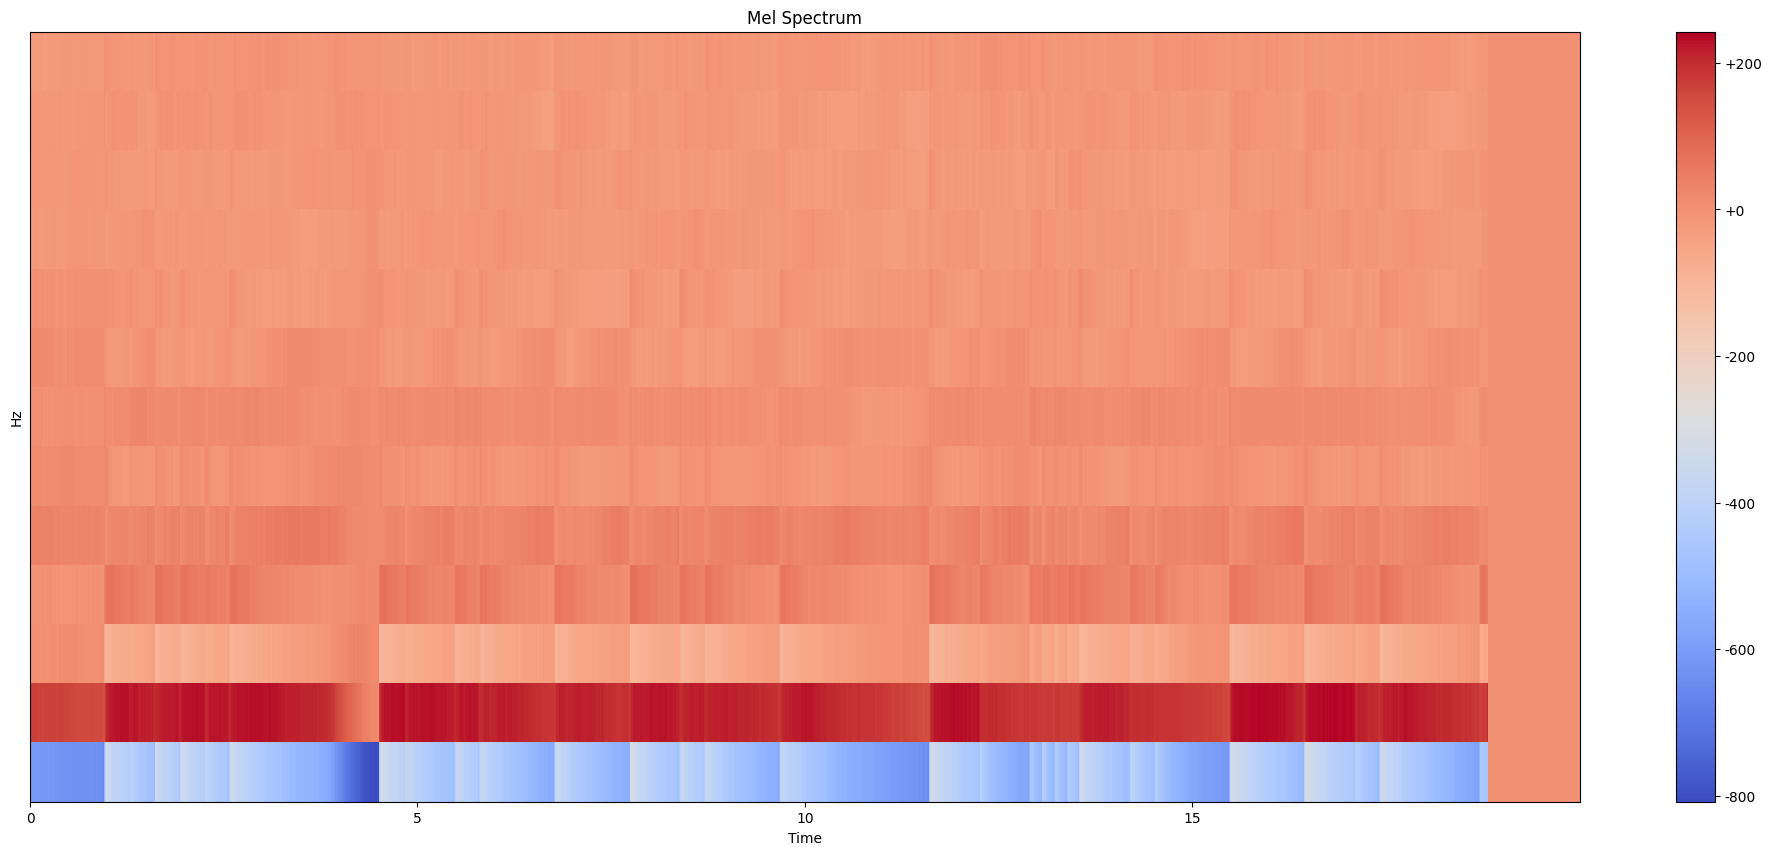

In [ ]:
# Visualize MFCCs
mfccs = x_train[0].T

import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfccs,
                         x_axis="time",
                         sr = 44100)
plt.colorbar(format="%+2.f")
plt.title('Mel Spectrum')
plt.ylabel('Hz')
plt.show()

**Model Building**

Music is a time series data, i.e., music is linear to time. Therefore we classify music genres by training an RNN-LTSM model, which excels at extracting patterns in input feature space where the input data spans over long sequences, making it ideal for such classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
class ClassifierLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes = 12, dropout_prob = 0.5):
    super(ClassifierLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #lstm layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
    #intermediate fully connected layer to match output size
    self.fc_intermediate = nn.Linear(2 * hidden_size, hidden_size)
    #dropout layer to improve generalization
    self.dropout = nn.Dropout(dropout_prob)
    #fully connected layer
    self.fc = nn.Linear(hidden_size, num_classes)

    # Move all parameter tensors to the desired device (GPU if available)
    self.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

  def forward(self, x):
    #Set the initial hidden states
    h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device).float() #ensure that the model and data are on the same device (GPU)
    #initialize cell state
    c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device).float() #ensure that the model and data are on the same device (GPU)
    #forward propagate the lstm
    out, _ = self.lstm(x, (h0, c0))
    #apply fully connected layer to match output size
    out = self.fc_intermediate(out)
    # Get the last time step's output
    out = out[:, -1, :]
    #Apply dropout to the LSTM output
    out = self.dropout(out)
    #Decode the hidden state of the last time step
    out = self.fc(out)
    # Apply softmax activation to obtain class probabilities
    out = torch.softmax(out, dim=1)
    return out


In [ ]:
def get_accuracy(model, data):
  correct, total = 0, 0
  for mfcc, label in data:
    mfcc = mfcc.to(device, dtype=torch.float32)
    label = torch.argmax(label, dim=1)  # Convert one-hot encoded label to scalar label
    label = label.to(device, dtype=torch.long)
    output = model(mfcc)
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(label.view_as(pred)).sum().item()
    total += label.size(dim = 0)
  return correct / total

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def train(model, train, val, batch_size, num_epochs = 200, lr = 0.001):
    torch.manual_seed(1000)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, train_acc, val_acc = [], [], []
    epochs = []
    #create dataloader for the training and val dataset
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

    # Convert the model's parameters to torch.float32
    for param in model.parameters():
        param.data = param.data.to(torch.float32)

    for epoch in range(num_epochs):

      #model.train() #set the model to training mode

      for mfcc, labels in train_loader:
        # Move inputs and labels to the selected device and convert to float32
        mfcc = mfcc.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        pred = model(mfcc)

        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

      train_loss.append(float(loss))

      #model.eval() #set the model to evaluation mode

      with torch.no_grad(): #Disable gradient calculation for validation
        val_acc.append(get_accuracy(model, val_loader))
        train_acc.append(get_accuracy(model, train_loader))

      epochs.append(epoch)
      print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_acc[-1]))

    print('Training done!')
    # plotting
    plt.title("Training Curve")
    plt.plot(train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
model = ClassifierLSTM(input_size=13, hidden_size=64, num_layers=2, num_classes=12, dropout_prob=0.5)
print(model)

ClassifierLSTM(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc_intermediate): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)


In [ ]:
model.to(device)

ClassifierLSTM(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc_intermediate): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)

In [ ]:
train(model, train_ds, val_ds, batch_size = 256)

Epoch 1; Loss 0.725487; Train Acc 0.663942; Val Acc 0.670833
Epoch 2; Loss 0.717809; Train Acc 0.662588; Val Acc 0.666414
Epoch 3; Loss 0.720206; Train Acc 0.647158; Val Acc 0.637374
Epoch 4; Loss 0.719777; Train Acc 0.654196; Val Acc 0.667677
Epoch 5; Loss 0.717887; Train Acc 0.660964; Val Acc 0.653157
Epoch 6; Loss 0.720002; Train Acc 0.653384; Val Acc 0.667677
Epoch 7; Loss 0.721260; Train Acc 0.654467; Val Acc 0.667045
Epoch 8; Loss 0.717611; Train Acc 0.655820; Val Acc 0.670202
Epoch 9; Loss 0.723210; Train Acc 0.649053; Val Acc 0.663889
Epoch 10; Loss 0.720184; Train Acc 0.662588; Val Acc 0.680303
Epoch 11; Loss 0.719046; Train Acc 0.657986; Val Acc 0.683460
Epoch 12; Loss 0.719606; Train Acc 0.656362; Val Acc 0.669571
Epoch 13; Loss 0.722370; Train Acc 0.653384; Val Acc 0.679040
Epoch 14; Loss 0.717285; Train Acc 0.659339; Val Acc 0.672727
Epoch 15; Loss 0.716316; Train Acc 0.659339; Val Acc 0.677146
Epoch 16; Loss 0.721021; Train Acc 0.662047; Val Acc 0.673359
Epoch 17; Loss 0.

KeyboardInterrupt: ignored

In [ ]:
#save the parameters
file_path = 'classifier.pth'

# Save the model's state dictionary to the .pth file
torch.save(model.state_dict(), file_path)